У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [960]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks

In [962]:
df = pd.read_csv('customer_segmentation_train.csv')

In [964]:
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [966]:
df.shape

(8068, 11)

In [968]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [970]:
df.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [972]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes('object').columns.tolist()
categorical_cols.remove('Segmentation')
print(numeric_cols)
print(categorical_cols)

['ID', 'Age', 'Work_Experience', 'Family_Size']
['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']


Дані містять категоріальні та числові колонки.

Пропущені значення є в колонках: 
числові - WorkExperience, 
категоріальні - EverMarrried, Graduated, Profession, FamilySize, Var_1.


### Заповнення пропусків

Заповнення пропущених значень для Ever_Married.

Для цього групую по віку та статі та заповнюю модою.

In [977]:
df['Ever_Married'].value_counts()

Ever_Married
Yes    4643
No     3285
Name: count, dtype: int64

In [979]:
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 18, 25, 30, 35, 45, 60, 100], 
                        labels = ['0-18', '19-25', '26-30', '31-35', '36-45', '46-60', '60+'])

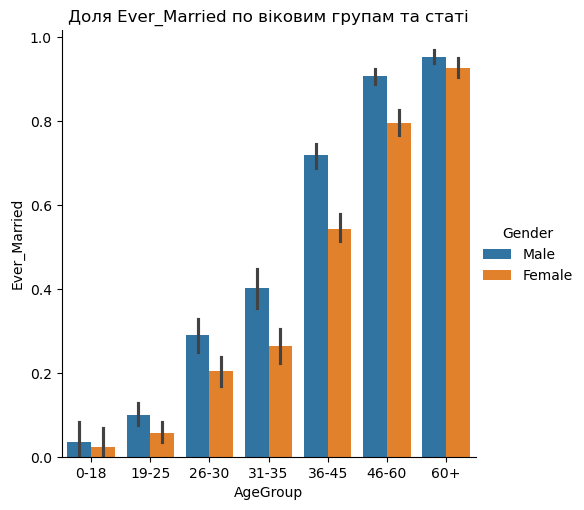

In [981]:
sns.catplot(x = 'AgeGroup', y = df['Ever_Married'].map({'No': 0, 'Yes': 1}), hue = 'Gender', kind = 'bar', data = df)
plt.title('Доля Ever_Married по віковим групам та статі')
plt.show()

З графiку видно що пропуски заповняться ʼYesʼ для всих віком більше 35.

In [984]:
df['Ever_Married'] = df['Ever_Married'].fillna(df.groupby(['AgeGroup', 'Gender'], observed=False)['Ever_Married'].transform(lambda x: x.mode()[0]))

Заповнюю пропуски для Profession

In [987]:
df['Profession'].value_counts() 

Profession
Artist           2516
Healthcare       1332
Entertainment     949
Engineer          699
Doctor            688
Lawyer            623
Executive         599
Marketing         292
Homemaker         246
Name: count, dtype: int64

In [989]:
df['Profession'] = df['Profession'].fillna('Unknown')

Заповнення пропусків для Graduated

In [992]:
def bi_cat_countplot(df, column, hue_column):
    unique_hue_values = df[hue_column].unique()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(14,6)

    pltname = f'Нормалізований розподіл значень за категорією: {column}'
    proportions = df.groupby(hue_column)[column].value_counts(normalize=True)
    proportions = (proportions*100).round(2)
    ax = proportions.unstack(hue_column).sort_values(
        by=unique_hue_values[0], ascending=False
        ).plot.bar(ax=axes[0], title=pltname)

    # анотація значень в барплоті
    for container in ax.containers:
        ax.bar_label(container, fmt='{:,.1f}%')

    pltname = f'Кількість даних за категорією: {column}'
    counts = df.groupby(hue_column)[column].value_counts()
    ax = counts.unstack(hue_column).sort_values(
        by=unique_hue_values[0], ascending=False
        ).plot.bar(ax=axes[1], title=pltname)

    for container in ax.containers:
      ax.bar_label(container)

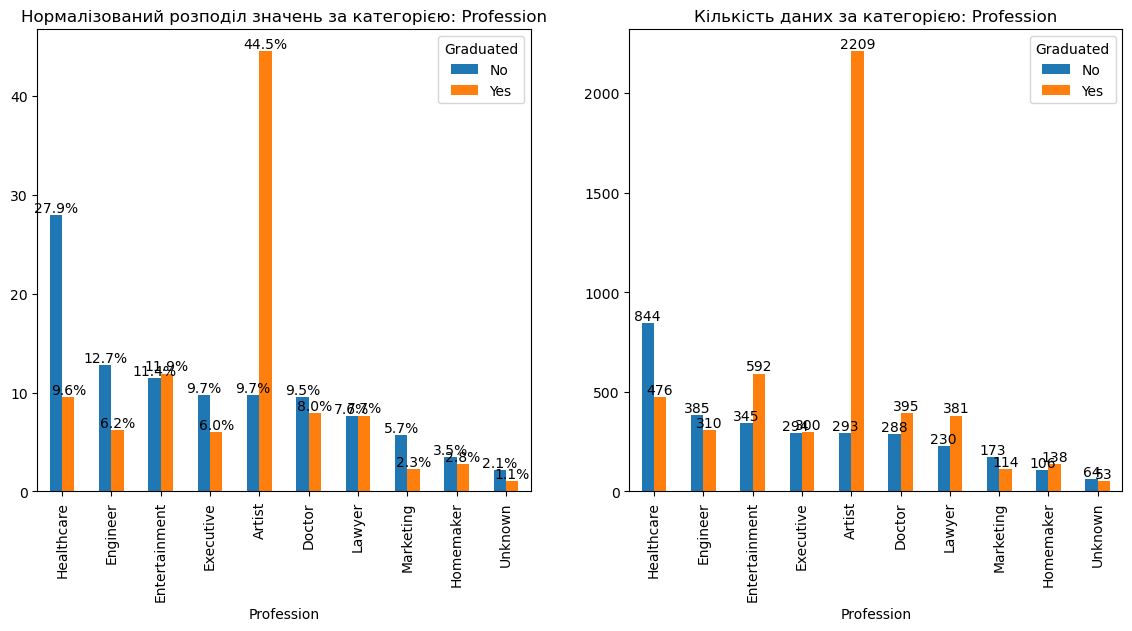

In [994]:
bi_cat_countplot(df, 'Profession', 'Graduated')

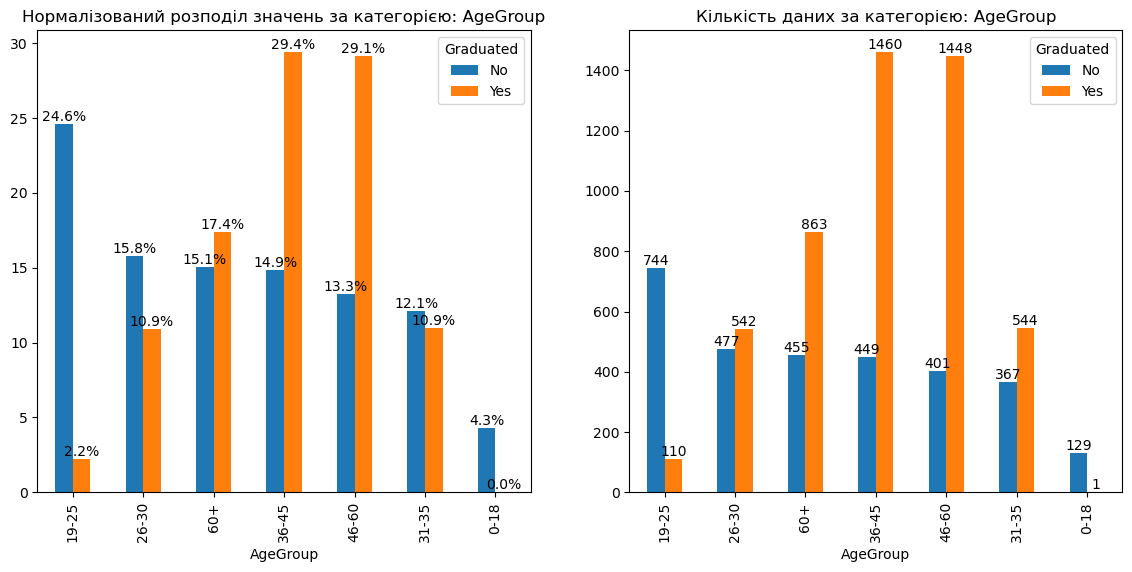

In [996]:
bi_cat_countplot(df, 'AgeGroup', 'Graduated')

Видно що розподiл Graduated відрізняєть у групах AgeGroup та Profession тому заповнюю пропущені значення в залежності від цих груп.

In [999]:
df['Graduated'] = df['Graduated'].fillna(df.groupby(['AgeGroup', 'Profession'], observed=False)
                                          ['Graduated'].transform(lambda x: x.mode()[0])).fillna('No')

Заповнюю пропуски для FamilySize

In [1002]:
df['Family_Size'].value_counts()

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


Family_Size
2.0    2390
3.0    1497
1.0    1453
4.0    1379
5.0     612
6.0     212
7.0      96
8.0      50
9.0      44
Name: count, dtype: int64

In [1006]:
df['Family_Size'].isnull().sum()

335

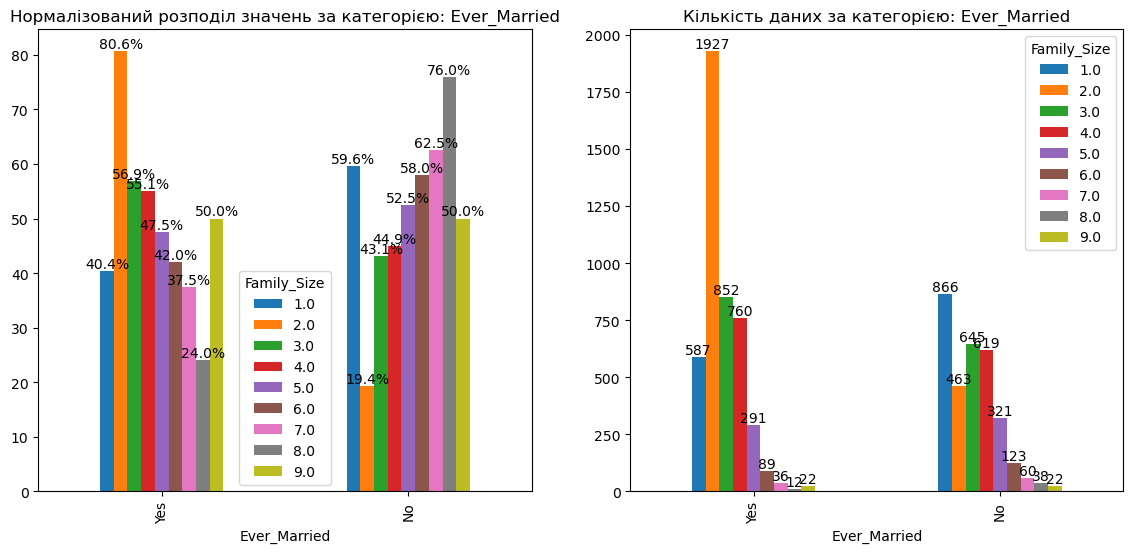

In [1008]:
bi_cat_countplot(df, 'Ever_Married', 'Family_Size')

Заповню модою враховуючи категорію Ever_Married: якщо Ever_Married = No то Family_Size стане 1, якщо Yes - 2.

In [1011]:
df['Family_Size'] = df.groupby('Ever_Married')['Family_Size'].transform(lambda x: x.fillna(x.mode()[0]))

Заповнення пропусків для var_1. Заповнюю значення модою.

In [1014]:
df['Var_1'].value_counts()

Var_1
Cat_6    5238
Cat_4    1089
Cat_3     822
Cat_2     422
Cat_7     203
Cat_1     133
Cat_5      85
Name: count, dtype: int64

In [1016]:
df['Var_1'] = df['Var_1'].fillna(df['Var_1'].mode()[0])

Заповнення пропусків для Work_Experience. Заповнюю модою групуючи по AgeGroup.

In [1019]:
df['Work_Experience'].value_counts()

Work_Experience
1.0     2354
0.0     2318
9.0      474
8.0      463
2.0      286
3.0      255
4.0      253
6.0      204
7.0      196
5.0      194
10.0      53
11.0      50
12.0      48
13.0      46
14.0      45
Name: count, dtype: int64

In [1021]:
agegroup_mode = df.groupby('AgeGroup',observed=False)['Work_Experience'].apply(lambda x: x.mode()[0])
print(agegroup_mode)

AgeGroup
0-18     0.0
19-25    1.0
26-30    0.0
31-35    0.0
36-45    0.0
46-60    1.0
60+      1.0
Name: Work_Experience, dtype: float64


In [1023]:
df['Work_Experience'] = df.groupby('AgeGroup',observed=False)['Work_Experience'].transform(lambda x: x.fillna(x.mode()[0]))

In [1025]:
df.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
AgeGroup           0
dtype: int64

### Кодування категоріальних колонок

Застосовую OrdinalEncoder для колонки Spending_Score та OneHotEncoder для інших категоріальних колонок.

In [1028]:
df[categorical_cols].nunique().sort_values(ascending = False)

Profession        10
Var_1              7
Spending_Score     3
Gender             2
Ever_Married       2
Graduated          2
dtype: int64

In [1030]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [1032]:
cat_ohe = categorical_cols
cat_ohe.remove('Spending_Score')

encoder.fit(df[cat_ohe])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [1034]:
encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Artist', 'Doctor', 'Engineer', 'Entertainment', 'Executive',
        'Healthcare', 'Homemaker', 'Lawyer', 'Marketing', 'Unknown'],
       dtype=object),
 array(['Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5', 'Cat_6', 'Cat_7'],
       dtype=object)]

In [1036]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Gender_Female', 'Gender_Male', 'Ever_Married_No', 'Ever_Married_Yes', 'Graduated_No', 'Graduated_Yes', 'Profession_Artist', 'Profession_Doctor', 'Profession_Engineer', 'Profession_Entertainment', 'Profession_Executive', 'Profession_Healthcare', 'Profession_Homemaker', 'Profession_Lawyer', 'Profession_Marketing', 'Profession_Unknown', 'Var_1_Cat_1', 'Var_1_Cat_2', 'Var_1_Cat_3', 'Var_1_Cat_4', 'Var_1_Cat_5', 'Var_1_Cat_6', 'Var_1_Cat_7']


In [1038]:
df[encoded_cols] = encoder.transform(df[categorical_cols])

In [1040]:
ordenc = OrdinalEncoder(categories=[['Low', 'Average', 'High']]) 
ordenc.fit(df[['Spending_Score']])
df['Spending_Score_Codes'] = ordenc.transform(df[['Spending_Score']])

In [1042]:
encoded_cols += ['Spending_Score_Codes']

In [1044]:
encoded_cols

['Gender_Female',
 'Gender_Male',
 'Ever_Married_No',
 'Ever_Married_Yes',
 'Graduated_No',
 'Graduated_Yes',
 'Profession_Artist',
 'Profession_Doctor',
 'Profession_Engineer',
 'Profession_Entertainment',
 'Profession_Executive',
 'Profession_Healthcare',
 'Profession_Homemaker',
 'Profession_Lawyer',
 'Profession_Marketing',
 'Profession_Unknown',
 'Var_1_Cat_1',
 'Var_1_Cat_2',
 'Var_1_Cat_3',
 'Var_1_Cat_4',
 'Var_1_Cat_5',
 'Var_1_Cat_6',
 'Var_1_Cat_7',
 'Spending_Score_Codes']

In [1046]:
numeric_cols.remove('ID')

### Розбиття на тренувальну та тестову вибірки

In [1049]:
X = df.drop('Segmentation', axis=1)
y = df.Segmentation

In [1051]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)

**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

In [1054]:
encoded_cols_indices = [X_train[encoded_cols+numeric_cols].columns.get_loc(col) for col in encoded_cols]
print(encoded_cols_indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [1056]:
smotenc = SMOTENC(categorical_features = encoded_cols_indices, random_state=0)
X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train[encoded_cols+numeric_cols], y_train)

In [1057]:
y_train_smotenc.value_counts()

Segmentation
D    1814
A    1814
C    1814
B    1814
Name: count, dtype: int64

In [1058]:
tomek = TomekLinks()
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train[encoded_cols+numeric_cols], y_train)

In [1059]:
y_train_tomek.value_counts()

Segmentation
D    1577
B    1486
C    1342
A    1261
Name: count, dtype: int64

**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

In [1065]:
log_reg = LogisticRegression(solver='liblinear')
ovr_model = OneVsRestClassifier(log_reg)
ovr_model.fit(X_train[encoded_cols+numeric_cols], y_train)
ovr_predictions = ovr_model.predict(X_test[encoded_cols+numeric_cols])

print(classification_report(y_test, ovr_predictions))

              precision    recall  f1-score   support

           A       0.40      0.45      0.42       394
           B       0.37      0.11      0.17       372
           C       0.46      0.69      0.56       394
           D       0.65      0.67      0.66       454

    accuracy                           0.49      1614
   macro avg       0.47      0.48      0.45      1614
weighted avg       0.48      0.49      0.46      1614



In [1067]:
log_reg = LogisticRegression(solver='liblinear')
ovr_model = OneVsRestClassifier(log_reg)
ovr_model.fit(X_train_smotenc, y_train_smotenc)
ovr_predictions = ovr_model.predict(X_test[encoded_cols+numeric_cols])

print(classification_report(y_test, ovr_predictions))

              precision    recall  f1-score   support

           A       0.41      0.47      0.44       394
           B       0.39      0.15      0.22       372
           C       0.46      0.67      0.55       394
           D       0.67      0.65      0.66       454

    accuracy                           0.50      1614
   macro avg       0.48      0.48      0.46      1614
weighted avg       0.49      0.50      0.47      1614



In [1069]:
log_reg = LogisticRegression(solver='liblinear')
ovr_model = OneVsRestClassifier(log_reg)
ovr_model.fit(X_train_tomek, y_train_tomek)
ovr_predictions = ovr_model.predict(X_test[encoded_cols+numeric_cols])

print(classification_report(y_test, ovr_predictions))

              precision    recall  f1-score   support

           A       0.42      0.39      0.41       394
           B       0.37      0.28      0.32       372
           C       0.49      0.63      0.55       394
           D       0.65      0.67      0.66       454

    accuracy                           0.50      1614
   macro avg       0.48      0.49      0.48      1614
weighted avg       0.49      0.50      0.49      1614



Обрала метрику Macro оскільки данi бiльш-менш збалансовані на тесті, та ми не знаємо значення груп А, B, C, D - чи є якіссь важливі а якісь ні, тому використовую Macro вважаючи що всі класи важливі.

Найкращою є модель натренована на збалансованих з Smote-Tomek даних. Також можна оцінити моделі за метриками для кожного класу окремо бо їх всьго 4. Бачимо що остання модель на порядок краще впоралась з класом B, recall збiльшився з 11 та 15 до 28, що і повпливало на f1.